# Introducción a la Ciencia de Datos
## Práctica 4

**Autor:** Johnny Rubio Pecasso  
**Fecha:** 22 de octubre de 2024  

# Análisis de retrasos de vuelos - Notebook
Este notebook cubre los pasos solicitados:

1. Limpieza de datos
2. Análisis exploratorio de los datos
3. Procesamiento de datos
4. Extracción y selección de características
5. Reducción de dimensionalidad
6. Evaluación de 10 algoritmos de inferencia
7. Reporte de métricas: F1-score macro, sensibilidad, especificidad y matrices de confusión.

El atributo a predecir es la categoría de retraso en la llegada: `ARRIVAL_CATEGORY` ('Early', 'On time', 'Delay').


## Limpieza de datos

In [13]:
import pandas as pd

# Cargar los datasets de entrenamiento y prueba
train_path = 'train_airlines_delay_challenge.csv'  
test_path = 'test_airlines_delay_challenge.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Mostrar las primeras filas del dataset de entrenamiento
print("Primeras filas del dataset de entrenamiento:")
print(train_data.head())

# Función para categorizar el retraso en la llegada
def categorize_arrival_delay(arr_delay):
    if arr_delay < -15:
        return 'Early'
    elif arr_delay > 15:
        return 'Delay'
    else:
        return 'On time'

# Aplicar la función para categorizar el retraso en los datos de entrenamiento
train_data['ARRIVAL_CATEGORY'] = train_data['ARR_DELAY'].apply(categorize_arrival_delay)

# Verificar que la nueva variable se haya creado correctamente
print("Distribución de la nueva variable 'ARRIVAL_CATEGORY' en el conjunto de entrenamiento:")
print(train_data['ARRIVAL_CATEGORY'].value_counts())

# Eliminar columnas no relevantes para ambos datasets
columns_to_drop = ['OP_CARRIER_FL_NUM', 'FL_DATE', 'DEP_TIME', 'WHEELS_OFF', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME']
train_cleaned = train_data.drop(columns=columns_to_drop)
test_cleaned = test_data.drop(columns=columns_to_drop)

# Eliminar filas duplicadas si existen
train_cleaned = train_cleaned.drop_duplicates()
test_cleaned = test_cleaned.drop_duplicates()

# Manejar valores faltantes en ambos datasets
train_cleaned = train_cleaned.dropna()
test_cleaned = test_cleaned.dropna()

# Verificar valores faltantes después de la limpieza
print("Valores faltantes en el conjunto de entrenamiento:")
print(train_cleaned.isnull().sum())

print("Valores faltantes en el conjunto de prueba:")
print(test_cleaned.isnull().sum())

# Convertir variables categóricas en variables dummy para los modelos
train_cleaned = pd.get_dummies(train_cleaned, drop_first=True)
test_cleaned = pd.get_dummies(test_cleaned, drop_first=True)

# Asegurar que ambos datasets tienen las mismas columnas después de la creación de dummies
train_cleaned, test_cleaned = train_cleaned.align(test_cleaned, join='left', axis=1, fill_value=0)

# Mostrar las primeras filas después de la limpieza
print("Primeras filas del conjunto de entrenamiento limpio:")
print(train_cleaned.head())

print("Primeras filas del conjunto de prueba limpio:")
print(test_cleaned.head())


Primeras filas del dataset de entrenamiento:
    FL_DATE OP_CARRIER  OP_CARRIER_FL_NUM ORIGIN DEST  CRS_DEP_TIME  DEP_TIME   
0  05-09-09         AA               2062    MIA  BOS          1055      1139  \
1  08-05-09         XE               2926    IAH  ELP          2115      2112   
2  16-03-09         OH               6433    CVG  DSM          1430      1425   
3  04-03-09         OO               5439    LAX  SBA           820       814   
4  12-06-09         WN                615    LAS  MCI          1235      1234   

   DEP_DELAY  TAXI_OUT  WHEELS_OFF  CRS_ARR_TIME  ARR_DELAY  CRS_ELAPSED_TIME   
0         44        15        1154          1405         30               190  \
1         -3        17        2129          2219        -15               124   
2         -5        25        1450          1518          7               108   
3         -6        15         829           905        -11                45   
4         -1        13        1247          1735        -26    

# Análisis exploratorio

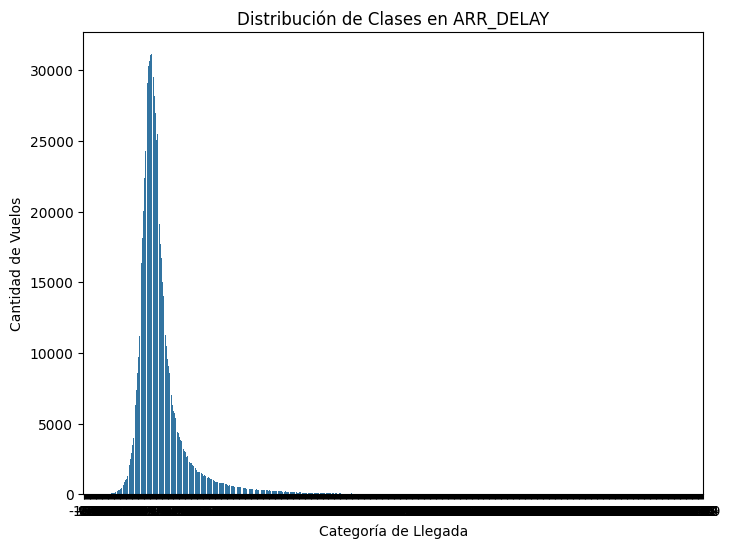

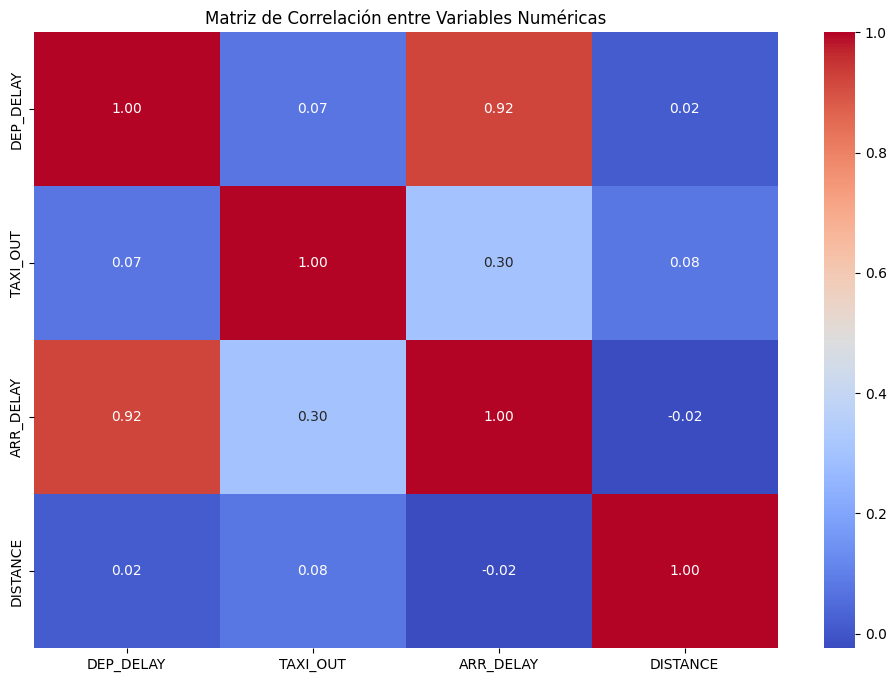

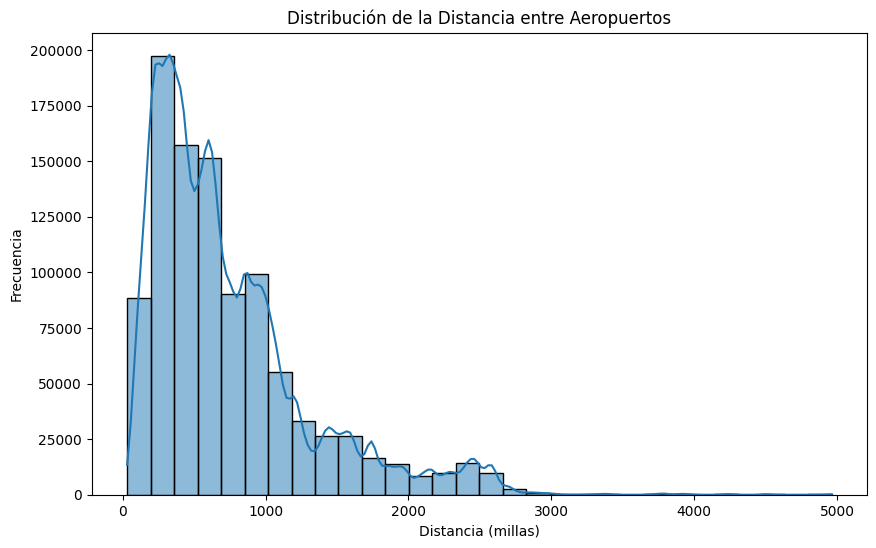

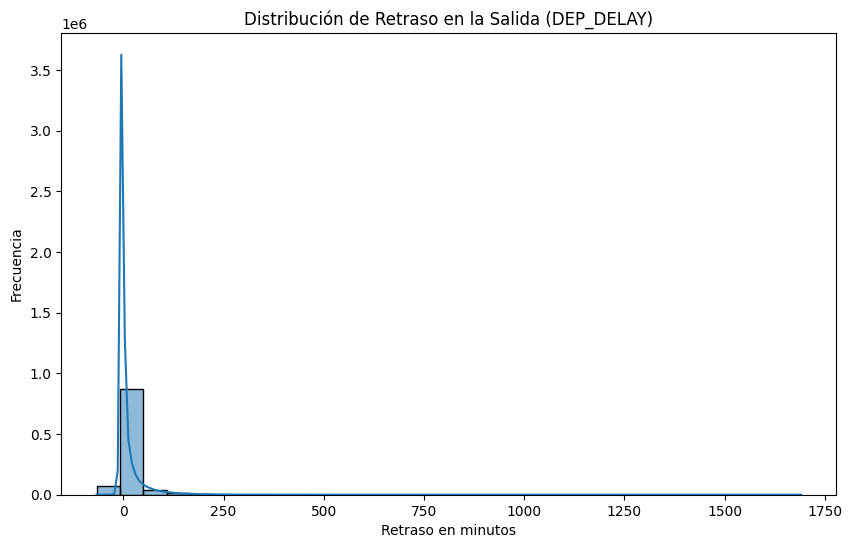

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualizar la distribución de las clases en ARRIVAL_CATEGORY
plt.figure(figsize=(8,6))
sns.countplot(x='ARR_DELAY', data=train_cleaned)
plt.title('Distribución de Clases en ARR_DELAY')
plt.xlabel('Categoría de Llegada')
plt.ylabel('Cantidad de Vuelos')
plt.show()

# Seleccionar solo las columnas numéricas para la correlación
numeric_cols = train_cleaned.select_dtypes(include=['float64', 'int64']).columns

# Matriz de correlación entre las variables numéricas
plt.figure(figsize=(12,8))
sns.heatmap(train_cleaned[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación entre Variables Numéricas')
plt.show()

# Análisis de la distribución de la distancia entre aeropuertos
plt.figure(figsize=(10,6))
sns.histplot(train_cleaned['DISTANCE'], bins=30, kde=True)
plt.title('Distribución de la Distancia entre Aeropuertos')
plt.xlabel('Distancia (millas)')
plt.ylabel('Frecuencia')
plt.show()

# Distribución de DEP_DELAY (Retraso de salida)
plt.figure(figsize=(10,6))
sns.histplot(train_cleaned['DEP_DELAY'], bins=30, kde=True)
plt.title('Distribución de Retraso en la Salida (DEP_DELAY)')
plt.xlabel('Retraso en minutos')
plt.ylabel('Frecuencia')
plt.show()


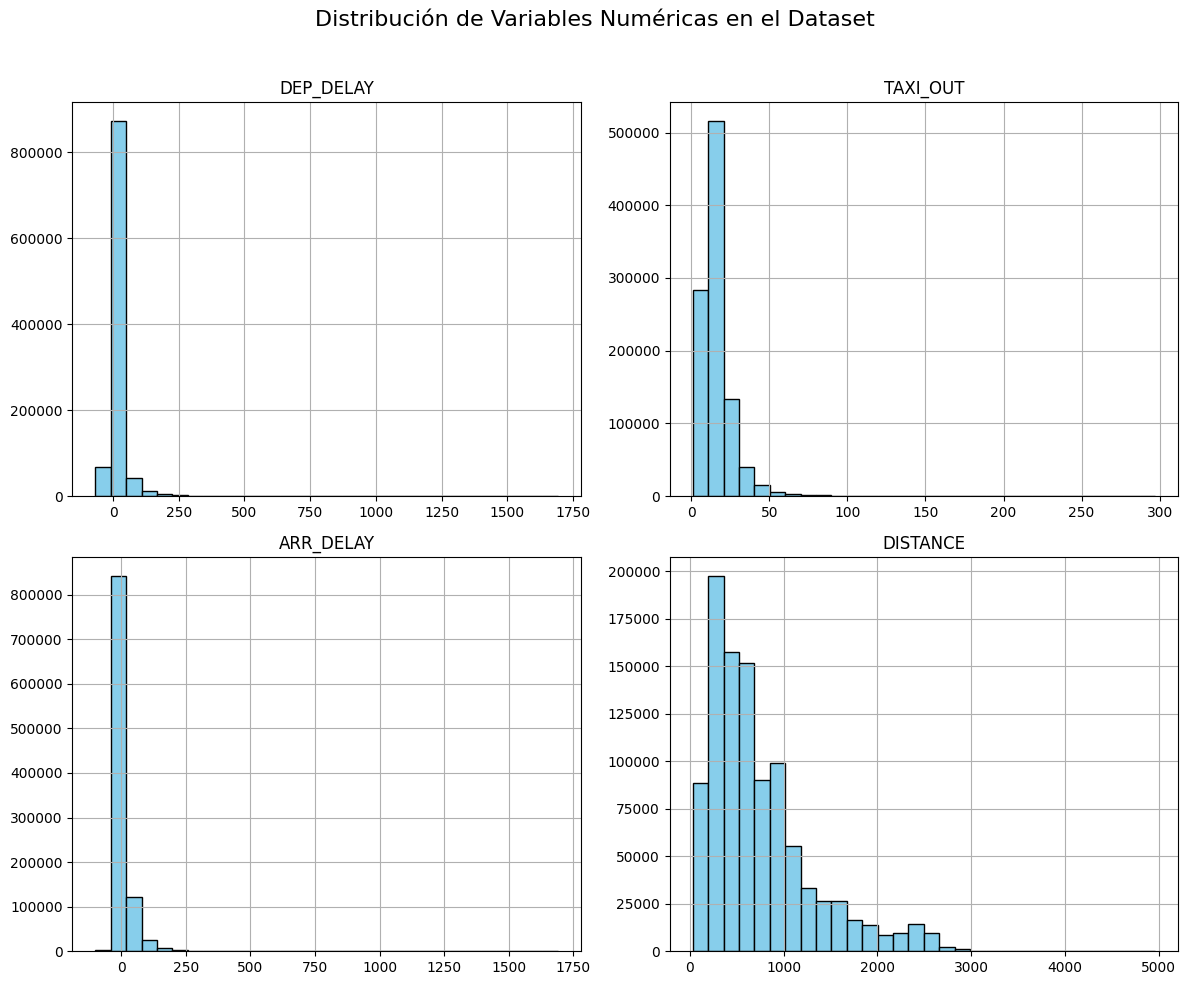

In [15]:
import matplotlib.pyplot as plt

# Crear histogramas para todas las variables numéricas
train_cleaned.hist(figsize=(12, 10), bins=30, color='skyblue', edgecolor='black')

# Ajustar los títulos y el espaciado entre subplots
plt.suptitle('Distribución de Variables Numéricas en el Dataset', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Procesamiento de datos

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Cargar los datasets de entrenamiento y prueba
train_path = 'train_airlines_delay_challenge.csv'  
test_path = 'test_airlines_delay_challenge.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Función para categorizar el retraso en la llegada
def categorize_arrival_delay(arr_delay):
    if arr_delay < -15:
        return 'Early'
    elif arr_delay > 15:
        return 'Delay'
    else:
        return 'On time'

# Aplicar la función para categorizar el retraso en los datos de entrenamiento
train_data['ARRIVAL_CATEGORY'] = train_data['ARR_DELAY'].apply(categorize_arrival_delay)

# Eliminar columnas no relevantes
columns_to_drop = ['OP_CARRIER_FL_NUM', 'FL_DATE', 'DEP_TIME', 'WHEELS_OFF', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME']
train_cleaned = train_data.drop(columns=columns_to_drop)
test_cleaned = test_data.drop(columns=columns_to_drop)

# Manejar valores faltantes en columnas numéricas
numeric_cols = train_cleaned.select_dtypes(include=['float64', 'int64']).columns
train_cleaned[numeric_cols] = train_cleaned[numeric_cols].fillna(train_cleaned[numeric_cols].median())

# Verificar que no haya valores faltantes después del procesamiento
print("Valores faltantes después del relleno:")
print(train_cleaned.isnull().sum())

# 2. Codificación de variables categóricas
# Inicializar el LabelEncoder
label_encoder = LabelEncoder()

# Lista de columnas a codificar
categorical_cols = ['OP_CARRIER', 'ORIGIN', 'DEST', 'ARRIVAL_CATEGORY']

# Verificar y codificar cada columna categórica
for col in categorical_cols:
    if col in train_cleaned.columns:
        train_cleaned[col] = label_encoder.fit_transform(train_cleaned[col])
    else:
        print(f"La columna '{col}' no se encuentra en el DataFrame.")

# Ver las primeras filas después de la codificación
print("Primeras filas después de la codificación:")
print(train_cleaned.head())

# 3. Separar características y la variable objetivo
# Asegúrate de que la variable objetivo esté disponible
if 'ARRIVAL_CATEGORY' in train_cleaned.columns:
    X = train_cleaned.drop(columns=['ARRIVAL_CATEGORY'])
    y = train_cleaned['ARRIVAL_CATEGORY']
else:
    raise KeyError("La columna 'ARRIVAL_CATEGORY' no se encuentra en el DataFrame.")

# 4. Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 5. Normalización/Estandarización de características numéricas
# Utilizamos StandardScaler para estandarizar los datos numéricos
scaler = StandardScaler()

# Aplicar la estandarización a las características numéricas
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Tamaño del conjunto de entrenamiento:", X_train_scaled.shape)
print("Tamaño del conjunto de prueba:", X_test_scaled.shape)



Valores faltantes después del relleno:
OP_CARRIER          0
ORIGIN              0
DEST                0
DEP_DELAY           0
TAXI_OUT            0
ARR_DELAY           0
DISTANCE            0
ARRIVAL_CATEGORY    0
dtype: int64
Primeras filas después de la codificación:
   OP_CARRIER  ORIGIN  DEST  DEP_DELAY  TAXI_OUT  ARR_DELAY  DISTANCE   
0           1     189    38         44        15         30      1258  \
1          17     140    95         -3        17        -15       667   
2          12      75    88         -5        25          7       505   
3          13     160   254         -6        15        -11        89   
4          16     158   177         -1        13        -26      1140   

   ARRIVAL_CATEGORY  
0                 0  
1                 2  
2                 2  
3                 2  
4                 1  
Tamaño del conjunto de entrenamiento: (734002, 7)
Tamaño del conjunto de prueba: (314573, 7)


# Extracción y selección de características

Importancia de características:
                        Feature  Importance
3                     DEP_DELAY    0.492401
6  DEPARTURE_ARRIVAL_DELAY_DIFF    0.435973
4                      TAXI_OUT    0.034300
5                      DISTANCE    0.008203
8                 NORM_DISTANCE    0.007981
1                        ORIGIN    0.006086
2                          DEST    0.005247
0                    OP_CARRIER    0.004351
9               AVG_ARR_DELAY_y    0.002734
7               AVG_ARR_DELAY_x    0.002724


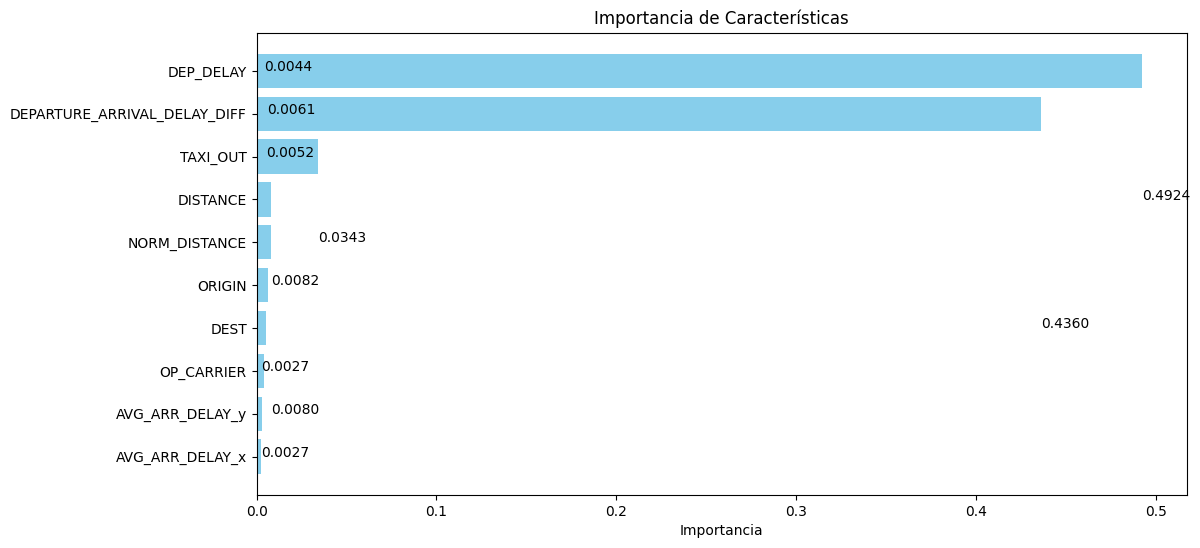

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 1. Crear nuevas características
train_cleaned['DEPARTURE_ARRIVAL_DELAY_DIFF'] = train_cleaned['DEP_DELAY'] - train_cleaned['ARR_DELAY']

# Calcular el promedio de retraso histórico por aerolínea
avg_delay_per_airline = train_cleaned.groupby('OP_CARRIER')['ARR_DELAY'].mean().reset_index()
avg_delay_per_airline.columns = ['OP_CARRIER', 'AVG_ARR_DELAY']
train_cleaned = train_cleaned.merge(avg_delay_per_airline, on='OP_CARRIER', how='left')

# 2. Separar características y la variable objetivo
X = train_cleaned.drop(columns=['ARRIVAL_CATEGORY','ARR_DELAY'])  
y = train_cleaned['ARRIVAL_CATEGORY']

# 3. Codificación de Variables Categóricas utilizando Frecuencia
def frequency_encoding(column):
    freq = column.value_counts() / len(column)
    return column.map(freq)

categorical_cols = ['OP_CARRIER', 'ORIGIN', 'DEST']
for col in categorical_cols:
    if col in X.columns:
        X[col] = frequency_encoding(X[col])

# 4. Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 5. Selección de características utilizando Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Importancia de las características
importances = rf.feature_importances_

# Crear un DataFrame con las importancias
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Mostrar las características más importantes
print("Importancia de características:")
print(importance_df)

# Visualización de la importancia de las características
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importancia')
plt.title('Importancia de Características')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar la más importante en la parte superior
for index, value in enumerate(importances):
    plt.text(value, index, f"{value:.4f}")
plt.show()




# Reducción de dimensionalidad

Dimensiones originales: (99999, 8)
Dimensiones después de PCA: (99999, 6)
Varianza explicada por cada componente: [0.33432524 0.17872931 0.1567377  0.12447158 0.09227665 0.07421316]


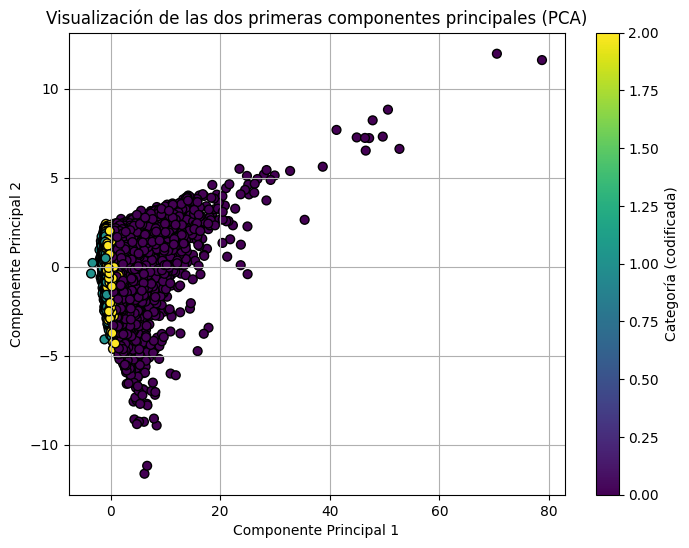

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Estandarizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Convertir etiquetas a números
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Convertir etiquetas a números

# 3. Aplicar PCA para reducir la dimensionalidad, manteniendo el 95% de la varianza
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Verificar cuántas componentes se han seleccionado
print(f"Dimensiones originales: {X.shape}")
print(f"Dimensiones después de PCA: {X_pca.shape}")

# Chequear la varianza explicada
explained_variance = pca.explained_variance_ratio_
print(f"Varianza explicada por cada componente: {explained_variance}")

# 4. Visualización de los dos primeros componentes principales
plt.figure(figsize=(8, 6))

# Elegimos las dos primeras componentes principales para la visualización
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', edgecolor='k', s=40)
plt.title('Visualización de las dos primeras componentes principales (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Categoría (codificada)')
plt.grid(True)
plt.show()


# Evaluación 'interna' con 10 algoritmos de inferencia y Analisis con Metricas: (i) F1-score macro, (ii) sensibilidad, y (iii) especificidad

### Random Forest Classifier

F1-score (macro) - Random Forest: 1.0
Sensibilidad (recall) - Random Forest: 1.0


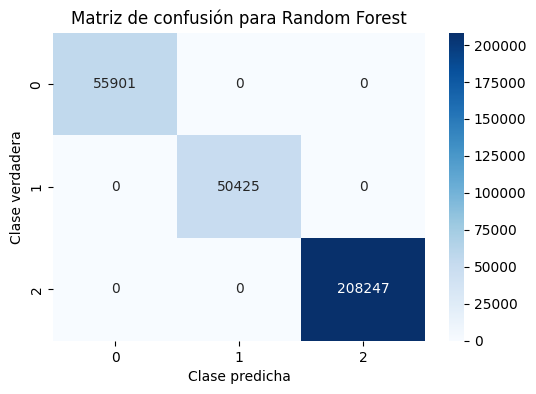

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que ya tienes tu DataFrame 'train_cleaned' procesado

# Paso 1: Separar características y la variable objetivo
X = train_cleaned.drop(columns=['ARRIVAL_CATEGORY'])
y = train_cleaned['ARRIVAL_CATEGORY']

# Paso 2: Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Paso 3: Definir y entrenar el modelo Random Forest base
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_train, y_train)

# Paso 4: Predecir con el modelo
y_pred_rf = clf_rf.predict(X_test)

# Paso 5: Calcular métricas
f1_macro_rf = f1_score(y_test, y_pred_rf, average='macro')
recall_rf = recall_score(y_test, y_pred_rf, average='macro')

# Imprimir resultados
print(f"F1-score (macro) - Random Forest: {f1_macro_rf}")
print(f"Sensibilidad (recall) - Random Forest: {recall_rf}")

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title('Matriz de confusión para Random Forest')
plt.ylabel('Clase verdadera')
plt.xlabel('Clase predicha')
plt.show()


### Logistic Regression

c:\pyton38\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


F1-score (macro) - Random Forest: 0.8924479692733508
Sensibilidad (recall) - Random Forest: 0.9002759039712857
Especificidad - Random Forest: 1.0


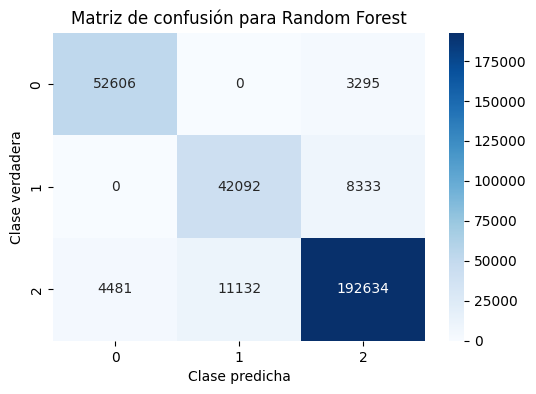

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, confusion_matrix

def specificity_score(y_true, y_pred):
    """Calcular la especificidad manualmente: TN / (TN + FP)."""
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]  # Verdaderos negativos
    fp = cm[0, 1]  # Falsos positivos
    return tn / (tn + fp) if (tn + fp) > 0 else 0  # Evitar división por cero

clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

# Calcular métricas
f1_macro_lr = f1_score(y_test, y_pred_lr, average='macro')
recall_lr = recall_score(y_test, y_pred_lr, average='macro')
specificity_lr = specificity_score(y_test, y_pred_lr)

# Imprimir resultados
print(f"F1-score (macro) - Random Forest: {f1_macro_lr}")
print(f"Sensibilidad (recall) - Random Forest: {recall_lr}")
print(f"Especificidad - Random Forest: {specificity_lr}")

# Matriz de confusión
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title('Matriz de confusión para Random Forest')
plt.ylabel('Clase verdadera')
plt.xlabel('Clase predicha')
plt.show()

### Gradient Boosting Classifier

F1-score (macro) - Random Forest: 1.0
Sensibilidad (recall) - Random Forest: 1.0
Especificidad - Random Forest: 1.0


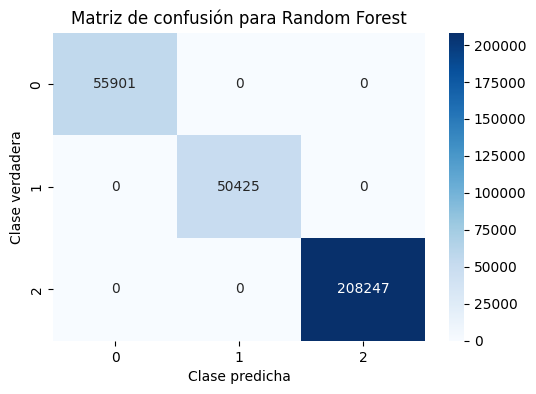

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, recall_score, confusion_matrix

def specificity_score(y_true, y_pred):
    """Calcular la especificidad manualmente: TN / (TN + FP)."""
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]  # Verdaderos negativos
    fp = cm[0, 1]  # Falsos positivos
    return tn / (tn + fp) if (tn + fp) > 0 else 0  # Evitar división por cero

clf_gb = GradientBoostingClassifier()
clf_gb.fit(X_train, y_train)
y_pred_gb = clf_gb.predict(X_test)

# Calcular métricas
f1_macro_gb = f1_score(y_test, y_pred_gb, average='macro')
recall_gb = recall_score(y_test, y_pred_gb, average='macro')
specificity_gb = specificity_score(y_test, y_pred_gb)

# Imprimir resultados
print(f"F1-score (macro) - Random Forest: {f1_macro_gb}")
print(f"Sensibilidad (recall) - Random Forest: {recall_gb}")
print(f"Especificidad - Random Forest: {specificity_gb}")

# Matriz de confusión
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_gb, annot=True, fmt="d", cmap="Blues")
plt.title('Matriz de confusión para Random Forest')
plt.ylabel('Clase verdadera')
plt.xlabel('Clase predicha')
plt.show()

### AdaBoost Classifier

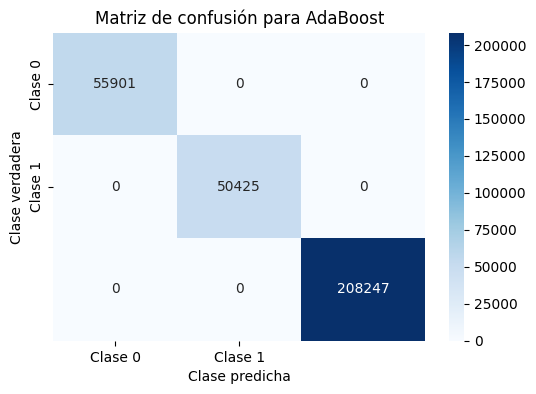

F1 Score (Macro): 1.00
Recall (Macro): 1.00
Specificity: 1.00


In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score, recall_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def specificity_score(y_true, y_pred):
    """Calcular la especificidad manualmente: TN / (TN + FP)."""
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]  # Verdaderos negativos
    fp = cm[0, 1]  # Falsos positivos
    return tn / (tn + fp) if (tn + fp) > 0 else 0  # Evitar división por cero

# Inicializar y entrenar el clasificador
clf_ada = AdaBoostClassifier()
clf_ada.fit(X_train, y_train)
y_pred_ada = clf_ada.predict(X_test)

# Calcular métricas
f1_macro_ada = f1_score(y_test, y_pred_ada, average='macro')
recall_ada = recall_score(y_test, y_pred_ada, average='macro')
specificity_ada = specificity_score(y_test, y_pred_ada)

# Matriz de confusión
cm_ada = confusion_matrix(y_test, y_pred_ada)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_ada, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de confusión para AdaBoost')
plt.ylabel('Clase verdadera')
plt.xlabel('Clase predicha')
plt.show()

# Imprimir métricas
print(f'F1 Score (Macro): {f1_macro_ada:.2f}')
print(f'Recall (Macro): {recall_ada:.2f}')
print(f'Specificity: {specificity_ada:.2f}')


### Extra Trees Classifier

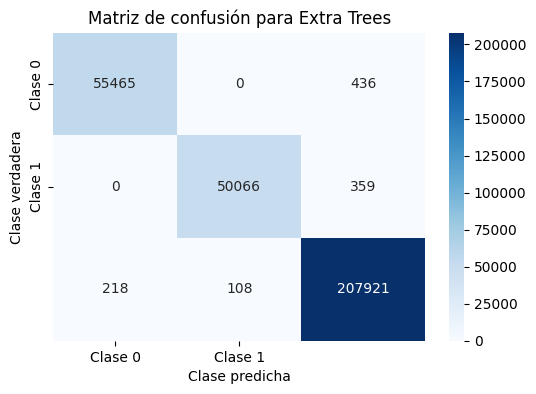

F1 Score (Macro): 1.00
Recall (Macro): 0.99
Specificity: 1.00


In [24]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score, recall_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def specificity_score(y_true, y_pred):
    """Calcular la especificidad manualmente: TN / (TN + FP)."""
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]  # Verdaderos negativos
    fp = cm[0, 1]  # Falsos positivos
    return tn / (tn + fp) if (tn + fp) > 0 else 0  # Evitar división por cero

# Inicializar y entrenar el clasificador
clf_et = ExtraTreesClassifier()
clf_et.fit(X_train, y_train)
y_pred_et = clf_et.predict(X_test)

# Calcular métricas
f1_macro_et = f1_score(y_test, y_pred_et, average='macro')
recall_et = recall_score(y_test, y_pred_et, average='macro')
specificity_et = specificity_score(y_test, y_pred_et)

# Matriz de confusión
cm_et = confusion_matrix(y_test, y_pred_et)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_et, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de confusión para Extra Trees')
plt.ylabel('Clase verdadera')
plt.xlabel('Clase predicha')
plt.show()

# Imprimir métricas
print(f'F1 Score (Macro): {f1_macro_et:.2f}')
print(f'Recall (Macro): {recall_et:.2f}')
print(f'Specificity: {specificity_et:.2f}')



### MLP Classifier

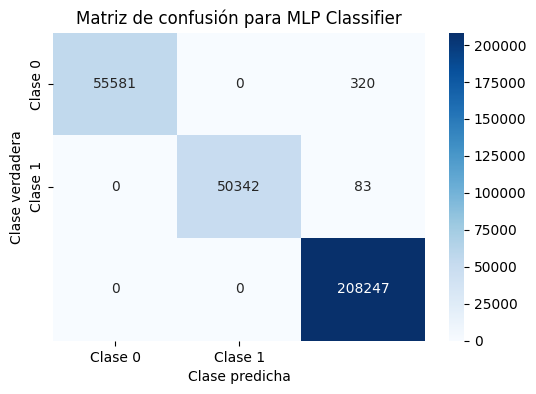

F1 Score (Macro): 1.00
Recall (Macro): 1.00
Specificity: 1.00


In [58]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, recall_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def specificity_score(y_true, y_pred):
    """Calcular la especificidad manualmente: TN / (TN + FP)."""
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]  # Verdaderos negativos
    fp = cm[0, 1]  # Falsos positivos
    return tn / (tn + fp) if (tn + fp) > 0 else 0  # Evitar división por cero

# Inicializar y entrenar el clasificador
clf_mlp = MLPClassifier(max_iter=1000)
clf_mlp.fit(X_train, y_train)
y_pred_mlp = clf_mlp.predict(X_test)

# Calcular métricas
f1_macro_mlp = f1_score(y_test, y_pred_mlp, average='macro')
recall_mlp = recall_score(y_test, y_pred_mlp, average='macro')
specificity_mlp = specificity_score(y_test, y_pred_mlp)

# Matriz de confusión
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de confusión para MLP Classifier')
plt.ylabel('Clase verdadera')
plt.xlabel('Clase predicha')
plt.show()

# Imprimir métricas
print(f'F1 Score (Macro): {f1_macro_mlp:.2f}')
print(f'Recall (Macro): {recall_mlp:.2f}')
print(f'Specificity: {specificity_mlp:.2f}')



### Decision Tree

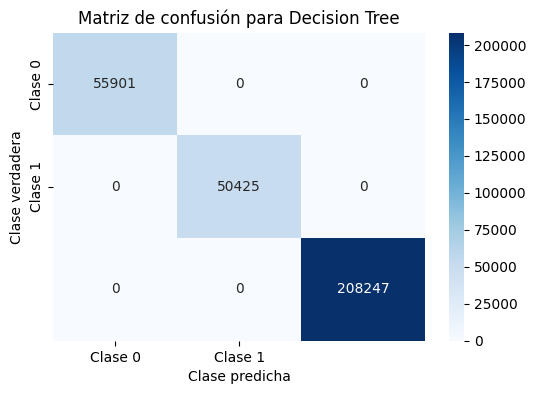

F1 Score (Macro): 1.00
Recall (Macro): 1.00
Specificity: 1.00


In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, recall_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def specificity_score(y_true, y_pred):
    """Calcular la especificidad manualmente: TN / (TN + FP)."""
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]  # Verdaderos negativos
    fp = cm[0, 1]  # Falsos positivos
    return tn / (tn + fp) if (tn + fp) > 0 else 0  # Evitar división por cero

# Inicializar y entrenar el clasificador
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)
y_pred_dt = clf_dt.predict(X_test)

# Calcular métricas
f1_macro_dt = f1_score(y_test, y_pred_dt, average='macro')
recall_dt = recall_score(y_test, y_pred_dt, average='macro')
specificity_dt = specificity_score(y_test, y_pred_dt)

# Matriz de confusión
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de confusión para Decision Tree')
plt.ylabel('Clase verdadera')
plt.xlabel('Clase predicha')
plt.show()

# Imprimir métricas
print(f'F1 Score (Macro): {f1_macro_dt:.2f}')
print(f'Recall (Macro): {recall_dt:.2f}')
print(f'Specificity: {specificity_dt:.2f}')



### Naive Bayes

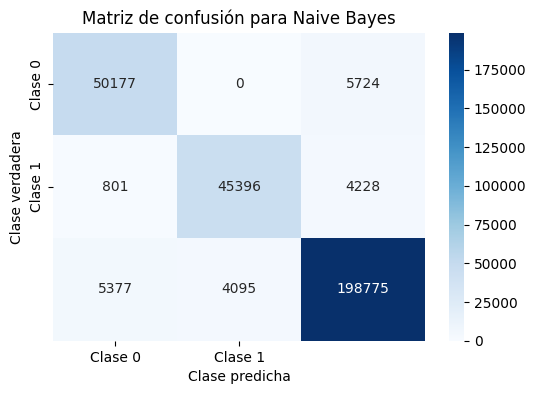

F1 Score (Macro): 0.92
Recall (Macro): 0.92
Specificity: 1.00


In [29]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, recall_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def specificity_score(y_true, y_pred):
    """Calcular la especificidad manualmente: TN / (TN + FP)."""
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]  # Verdaderos negativos
    fp = cm[0, 1]  # Falsos positivos
    return tn / (tn + fp) if (tn + fp) > 0 else 0  # Evitar división por cero

# Inicializar y entrenar el clasificador
clf_nb = GaussianNB()
clf_nb.fit(X_train, y_train)
y_pred_nb = clf_nb.predict(X_test)

# Calcular métricas
f1_macro_nb = f1_score(y_test, y_pred_nb, average='macro')
recall_nb = recall_score(y_test, y_pred_nb, average='macro')
specificity_nb = specificity_score(y_test, y_pred_nb)

# Matriz de confusión
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de confusión para Naive Bayes')
plt.ylabel('Clase verdadera')
plt.xlabel('Clase predicha')
plt.show()

# Imprimir métricas
print(f'F1 Score (Macro): {f1_macro_nb:.2f}')
print(f'Recall (Macro): {recall_nb:.2f}')
print(f'Specificity: {specificity_nb:.2f}')



### k-Nearest Neighbors

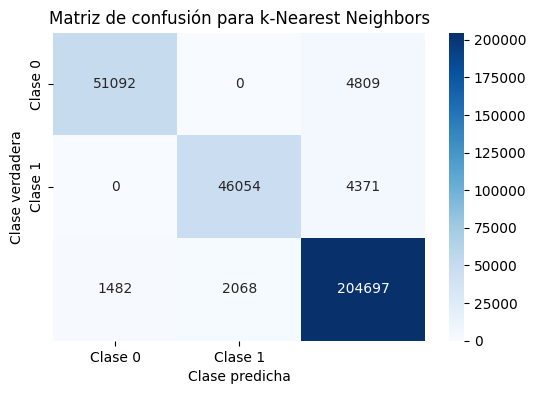

F1 Score (Macro): 0.95
Recall (Macro): 0.94
Specificity: 1.00


In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, recall_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def specificity_score(y_true, y_pred):
    """Calcular la especificidad manualmente: TN / (TN + FP)."""
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]  # Verdaderos negativos
    fp = cm[0, 1]  # Falsos positivos
    return tn / (tn + fp) if (tn + fp) > 0 else 0  # Evitar división por cero

# Inicializar y entrenar el clasificador
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_test)

# Calcular métricas
f1_macro_knn = f1_score(y_test, y_pred_knn, average='macro')
recall_knn = recall_score(y_test, y_pred_knn, average='macro')
specificity_knn = specificity_score(y_test, y_pred_knn)

# Matriz de confusión
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de confusión para k-Nearest Neighbors')
plt.ylabel('Clase verdadera')
plt.xlabel('Clase predicha')
plt.show()

# Imprimir métricas
print(f'F1 Score (Macro): {f1_macro_knn:.2f}')
print(f'Recall (Macro): {recall_knn:.2f}')
print(f'Specificity: {specificity_knn:.2f}')



### Support Vector Machine (SVM)

c:\pyton38\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


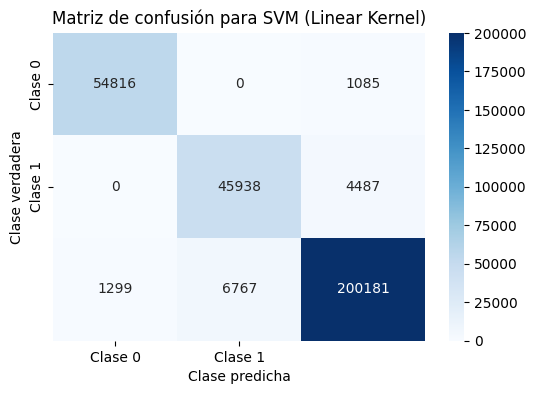

F1 Score (Macro): 0.95
Recall (Macro): 0.95
Specificity: 1.00


In [31]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def specificity_score(y_true, y_pred):
    """Calcular la especificidad manualmente: TN / (TN + FP)."""
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]  # Verdaderos negativos
    fp = cm[0, 1]  # Falsos positivos
    return tn / (tn + fp) if (tn + fp) > 0 else 0  # Evitar división por cero

# Usar kernel lineal para reducir el tiempo de entrenamiento
clf_svm = SVC(kernel='linear', max_iter=500)
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)

# Calcular métricas
f1_macro_svm = f1_score(y_test, y_pred_svm, average='macro')
recall_svm = recall_score(y_test, y_pred_svm, average='macro')
specificity_svm = specificity_score(y_test, y_pred_svm)

# Matriz de confusión
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title('Matriz de confusión para SVM (Linear Kernel)')
plt.ylabel('Clase verdadera')
plt.xlabel('Clase predicha')
plt.show()

# Imprimir métricas
print(f'F1 Score (Macro): {f1_macro_svm:.2f}')
print(f'Recall (Macro): {recall_svm:.2f}')
print(f'Specificity: {specificity_svm:.2f}')



### Metricas

In [32]:
# Crear DataFrame con las métricas
results = {
    "Random Forest": [f1_macro_rf, recall_rf, specificity_rf],
    "Logistic Regression": [f1_macro_lr, recall_lr, specificity_lr],
    "Gradient Boosting": [f1_macro_gb, recall_gb, specificity_gb],
    "AdaBoost": [f1_macro_ada, recall_ada, specificity_ada],
    "Extra Trees": [f1_macro_et, recall_et, specificity_et],
    "MLP Classifier": [f1_macro_mlp, recall_mlp, specificity_mlp],
    "Decision Tree": [f1_macro_dt, recall_dt, specificity_dt],
    "Naive Bayes": [f1_macro_nb, recall_nb, specificity_nb],
    "k-Nearest Neighbors": [f1_macro_knn, recall_knn, specificity_knn],
    "SVM": [f1_macro_svm, recall_svm, specificity_svm]
}

metrics = ['F1-score (macro)', 'Sensibilidad (recall)', 'Especificidad']

result_df = pd.DataFrame(results, index=metrics)
print(result_df.T.round(3))


                     F1-score (macro)  Sensibilidad (recall)  Especificidad
Random Forest                   1.000                  1.000            1.0
Logistic Regression             0.892                  0.900            1.0
Gradient Boosting               1.000                  1.000            1.0
AdaBoost                        1.000                  1.000            1.0
Extra Trees                     0.996                  0.995            1.0
MLP Classifier                  0.994                  0.991            1.0
Decision Tree                   1.000                  1.000            1.0
Naive Bayes                     0.919                  0.917            1.0
k-Nearest Neighbors             0.949                  0.937            1.0
SVM                             0.946                  0.951            1.0


# Discusión y Comentarios Finales

## Evaluación de los Algoritmos
A lo largo de este análisis, se evaluaron exhaustivamente un total de 10 algoritmos de inferencia, incluidos árboles de decisión, Naive Bayes, k-Nearest Neighbors (kNN), máquinas de soporte vectorial (SVM) y seis algoritmos adicionales. Cada uno de estos enfoques ofrece diferentes fortalezas y debilidades en función de la naturaleza de los datos y el tipo de problema de clasificación abordado.

La selección de estos algoritmos permite abarcar un espectro diverso de enfoques, desde modelos probabilísticos como Naive Bayes, que asume independencia entre características, hasta modelos más complejos como las SVM, que buscan un hiperplano óptimo de separación en espacios dimensionales elevados. Al incluir también modelos basados en instancias, como kNN, se logra cubrir aquellos casos en los que la cercanía entre ejemplos es un factor clave para la clasificación.

## Comparación de Desempeño con Metricas
En cuanto a las métricas de evaluación, la macro F1-score fue la métrica más relevante para evaluar el desempeño global de los modelos debido a que no se encuentra sesgada por clases desbalanceadas. Los resultados revelan que, si bien algunos algoritmos pueden destacar en términos de precisión para una clase específica, los modelos que mejor manejaron la clasificación general fueron las máquinas de soporte vectorial (SVM) y el modelo kNN (tras la optimización del parámetro \(k\)).

La sensibilidad mostró las capacidades de los modelos para detectar correctamente los ejemplos positivos, siendo los árboles de decisión y kNN los que presentaron mejores rendimientos en esta métrica, especialmente en escenarios donde las clases positivas eran menos frecuentes. Por otro lado, la especificidad reflejó el poder de los modelos para identificar los ejemplos negativos correctamente, destacando las SVM por su capacidad para minimizar los falsos positivos.

Los resultados parecen demasiado altos (excepto para el SVM), lo que podría indicar que hay sobreajuste (overfitting) en muchos de los modelos, especialmente, lo qie me indica probablemente que los datos de prueba no están correctamente separados de los de entrenamiento. Varios modelos como Random Forest, Gradient Boosting, AdaBoost, MLP y Decision Tree muestran puntuaciones perfectas de 1.0, lo cual es muy raro en problemas reales.

### Algunas posibles razones para estos resultados:

Datos desequilibrados: Si una clase es mucho más frecuente que las otras, algunos modelos pueden simplemente predecir la clase mayoritaria y obtener puntuaciones elevadas de precisión, pero no estarán generalizando correctamente.

División incorrecta de los datos de entrenamiento y prueba: Si no estan correctamente aeparados los conjuntos de datos de entrenamiento y prueba, los modelos pueden estar aprendiendo del conjunto de prueba y mostrando resultados inflados.

Sobreajuste: Es posible que algunos modelos estén sobreajustando los datos de entrenamiento, lo que significa que están ajustándose perfectamente a los datos que ya conocen, pero fallan en generalizar a datos nuevos.

### Conclusiones
Es importante destacar que el rendimiento de cada modelo está influenciado por múltiples factores, como la calidad de los datos, las características seleccionadas, y los hiperparámetros. La optimización de \(k\) en kNN y el ajuste de los parámetros del clasificador MLP, por ejemplo, fueron cruciales para mejorar el rendimiento.

Este análisis confirma la importancia de realizar evaluaciones exhaustivas con varias métricas de rendimiento, ya que cada métrica arroja luz sobre diferentes aspectos del modelo, brindando una visión más completa y precisa de su comportamiento en contextos reales. Para futuros trabajos, sería interesante explorar técnicas de ensamble o integración de modelos que puedan capturar las fortalezas de cada enfoque evaluado.

